<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/model/code/SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt

import numpy as np
import time
import copy

# Dataset

In [2]:
path2data = './data'

if not os.path.exists(path2data):
  os.mkdir(path2data)

train_ds = datasets.STL10(path2data, split='train',download=True,transform=transforms.ToTensor())
test_ds = datasets.STL10(path2data,split='test',download=True, transform=transforms.ToTensor())

print(len(train_ds),len(test_ds))

100%|██████████| 2640397119/2640397119 [02:05<00:00, 21050867.35it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
5000 8000


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

In [4]:
train_ds.transform= transform
test_ds.transform = transform

In [5]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [7]:
def show(img, y):

  arr = img.numpy()
  arr = np.transpose(arr,(1,2,0))
  plt.imshow(arr)

  plt.title('labels: '+str(y))

In [10]:
x,y = next(iter(train_loader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


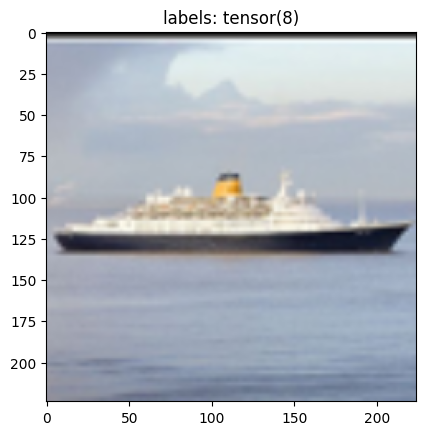

In [12]:
show(x[0],y[0])

# Model

In [39]:
class SEBlock(nn.Module):

  def __init__(self, in_channels, r=16):
    super(SEBlock, self).__init__()
    self.squeeze = nn.AdaptiveAvgPool2d(1)
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, in_channels//r),
        nn.ReLU(),
        nn.Linear(in_channels//r, in_channels),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.squeeze(x)
    x = x.view(x.size(0),-1)
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1),1,1)
    return x

## MobileNet

In [40]:
# Depthwise Separable Convolution

class Depthwise(nn.Module):

  def __init__(self, in_channels, out_channels, stride=1):
    super(Depthwise, self).__init__()
    self.depthwise = nn.Sequential(
        nn.Conv2d(in_channels, in_channels,3,stride=stride,padding=1,groups=in_channels,bias=False),
        nn.BatchNorm2d(in_channels),
        nn.ReLU6() # 상한 값을 6으로 한정
        )

    self.pointwise = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6()
    )

    self.seblock = SEBlock(out_channels)

  def forward(self, x):
    x = self.depthwise(x)
    x = self.pointwise(x)
    x = self.seblock(x)
    return x

- ReLU6를 사용하면 최대 3 bit만 있기 떄문에 최적화 관점에서 도움이 됨
- Sparse feature를 더 일찍 학습

In [41]:
class BasicConv2d(nn.Module):

  def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
    super(BasicConv2d, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6()
    )

  def forward(self, x):
    x = self.conv(x)
    return x

In [42]:
# MobileNet v1

class MobileNet(nn.Module):

  def __init__(self, width_multiplier, num_classes=10, init_weights=True):
    super(MobileNet, self).__init__()
    self.init_weights = init_weights
    alpha = width_multiplier

    self.conv1 = BasicConv2d(3, int(32*alpha), kernel_size=3, stride=2, padding=1)
    self.conv2 = Depthwise(int(32*alpha), int(64*alpha),stride=1)

    # Downsample
    self.conv3 = nn.Sequential(
        Depthwise(int(64*alpha), int(128*alpha), stride=2),
        Depthwise(int(128*alpha), int(128*alpha), stride=1)
    )

    self.conv4 = nn.Sequential(
        Depthwise(int(128*alpha), int(256*alpha), stride=2),
        Depthwise(int(256*alpha), int(256*alpha), stride=1)
    )

    self.conv5 = nn.Sequential(
        Depthwise(int(256*alpha), int(512*alpha), stride=2),
        Depthwise(int(512*alpha), int(512*alpha),stride=1),
        Depthwise(int(512*alpha), int(512*alpha),stride=1),
        Depthwise(int(512*alpha), int(512*alpha),stride=1),
        Depthwise(int(512*alpha), int(512*alpha),stride=1),
        Depthwise(int(512*alpha), int(512*alpha),stride=1)
    )

    self.conv6 = nn.Sequential(
        Depthwise(int(512 * alpha), int(1024 * alpha),stride=2)
    )

    self.conv7 = nn.Sequential(
        Depthwise(int(1024 * alpha), int(1024 * alpha),stride=2)
    )

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(int(1024 * alpha), num_classes)

    if self.init_weights:
      self._initialize_weights()

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m,nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight,0,0.01)
        nn.init.constant_(m.bias,0)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.avg_pool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
model = MobileNet(1.10).to(device)

In [45]:
summary(model, (3,224,224),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 35, 112, 112]             980
       BatchNorm2d-2         [-1, 35, 112, 112]              70
             ReLU6-3         [-1, 35, 112, 112]               0
       BasicConv2d-4         [-1, 35, 112, 112]               0
            Conv2d-5         [-1, 35, 112, 112]             315
       BatchNorm2d-6         [-1, 35, 112, 112]              70
             ReLU6-7         [-1, 35, 112, 112]               0
            Conv2d-8         [-1, 70, 112, 112]           2,450
       BatchNorm2d-9         [-1, 70, 112, 112]             140
            ReLU6-10         [-1, 70, 112, 112]               0
AdaptiveAvgPool2d-11             [-1, 70, 1, 1]               0
           Linear-12                    [-1, 4]             284
             ReLU-13                    [-1, 4]               0
           Linear-14                   

# 학습

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [69]:
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

In [70]:
# 현재 학습율 확인
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [71]:
# Calculate the metric per mini-batch
def metric_batch(output, target):
  pred = output.argmax(1,keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [72]:
# Calculate the loss per mini-batch
def loss_batch(loss_fn, output, target, opt=None):
  loss = loss_fn(output, target)
  metric = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric

In [73]:
# Calculate the loss per epoch
def loss_epoch(model, loss_fn, dataloader, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataloader.dataset)

  for x, y in dataloader:
    x = x.to(device)
    y = y.to(device)
    output = model(x)

    loss, metric = loss_batch(loss_fn, output, y, opt)

    running_loss += loss

    running_metric += metric

  loss = running_loss / len_data
  metric = running_metric / len_data

  return loss, metric

In [74]:
# 학습
def train(model, params):
  num_epochs = params['num_epochs']
  loss_fn = params['loss_fn']
  opt = params['optimizer']
  trainloader = params['trainloader']
  validloader = params['validloader']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {'train' : [], 'val' : []}
  metric_history = {'train' : [], 'val' : []}

  best_loss = float('inf')
  best_model_wts = copy.deepcopy(model.state_dict())
  start_time = time.time()

  patience = 3
  i = 0
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print(f'Epoch {epoch+1}/{num_epochs}, Current Learning Rate {current_lr}')

    model.train()
    train_loss, train_metric = loss_epoch(model, loss_fn, trainloader, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()

    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_fn, validloader)

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    if val_loss <= best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print('Copied best model weights!')
    else:
      i += 1
      if i >= patience:
        print('Early stopping!')
        break
    lr_scheduler.step(val_loss)

    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print(f'time : {(time.time()-start_time)/60:.4f}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_metric:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_metric:.4f}')
    print('-'*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [75]:
params_train = {'num_epochs' : 100, 'optimizer' : optimizer, 'loss_fn' : loss_fn, 'trainloader' : train_loader,
                'validloader' : test_loader, 'lr_scheduler' : lr_scheduler, 'path2weights' : './weights.pt'}

In [ ]:
model, loss_hist, metric_hist = train(model, params_train)

In [ ]:
num_epochs = params_train['num_epochs']

plt.title('Train-Val Loss')
plt.plot(range(1,num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1,num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1,num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1,num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()